<a href="https://colab.research.google.com/github/AnkitRajSri/Effects-of-Lockdown-on-Mental-Health/blob/master/Healthcare_Data_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Import

In [17]:
import pandas as pd
import numpy as np
import pickle
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [12]:
health_data = pd.read_pickle('health_data.pkl')
health_data.head()

,Date Added,Author,Title,Abstract,Year,Journal/Publisher,CleanedAbstract,KeywordsWords,KeywordsBigrams
0,2020-06-02,"Zhao, XL, M.; Li, H.; Yang, J.",Perceived stress and sleep quality among the n...,BACKGROUND: The 2019 coronavirus disease (COVI...,2020,Sleep medicine,disease spread worldwide associated stressor r...,"cancer, health, anxiety, healthcare, care","patient, case, mental, psychological, health"
1,2020-06-02,"Yang, KS, Y.; Huang, C.; Jin, Y.; Xiong, N.; J...","Clinical characteristics, outcomes, and risk f...",BACKGROUND: Patients with cancer are a high-ri...,2020,Lancet Oncology,patient cancer high risk population aimed desc...,"patient, infection, health, virus, study","patient, treatment, infection, respiratory, cl..."
2,2020-06-02,"Xu, YL, H.; Hu, K.; Wang, M.",Clinical recommendations on lung cancer manage...,Coronavirus disease 2019 (COVID-19) is spreadi...,2020,Thoracic Cancer,disease spreading worldwide declared internati...,"health, cancer, patient, treatment, risk","patient, health, social, care, measure"
3,2020-06-02,"Xiong, JB, L.; Qi, H.; Feng, Z.; Shi, Y.",Mesenchymal Stem Cell-based Therapy for COVID-...,"A novel coronavirus, named severe acute respir...",2020,Current stem cell research & therapy,named severe acute respiratory syndrome emerge...,"treatment, cell, response, drug, health","patient, drug, therapy, treatment, infection"
4,2020-06-02,"Wollina, UF, M.; Goldust, M.; Lotti, T.",Psoriatic Arthritis and COVID-19 Pandemic: Con...,The COVID-19 pandemic has a strong negative im...,2020,Dermatologic Therapy,strong negative impact human society world wid...,"patient, case, infection, disease, study","health, patient, respiratory, risk, infection"


### Input Preparation

##### TFIDF Input

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepared tfidf input for KMeans and similarity matrix for Agglomerative Clustering
list_of_headlines = health_data['CleanedAbstract'].tolist()
vector = TfidfVectorizer(max_features = 10000, min_df = 0.15, ngram_range = (1, 3))
tfidf = vector.fit_transform(list_of_headlines)
similarity_matrix = (tfidf * tfidf.T).A

##### Word2Vec Input

In [33]:
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

tokenized_list = [simple_preprocess(text) for text in health_data['Abstract']]
tokenized_corpus = np.array(tokenized_list)
num_features = 100

word2vec = Word2Vec(tokenized_corpus, size=num_features, window=8, min_count=2, sample=1e-3, sg=1, iter=5, workers=3)
vocabulary = set(word2vec.wv.index2word)

def calculateAverageWordVector(tokens, model, vocabulary, num_features):
  feature_vector = np.zeros((num_features,), dtype = 'float64')
  nwords = 0
  for word in tokens:
    if word in vocabulary:
      nwords += 1
      feature_vector = np.add(feature_vector, model.wv[word])
  if nwords:
    feature_vector = np.divide(feature_vector, nwords)
  return feature_vector

features = [calculateAverageWordVector(token, word2vec, vocabulary, num_features) for token in tokenized_corpus]
avg_features = np.array(features)
print(avg_features)

[[-1.58186775e-01  3.57046154e-01  1.20697268e-01 ...  4.23225918e-03
  -1.87406154e-01  6.96086622e-02]
 [-9.61461535e-02  3.35332998e-01 -4.01361656e-02 ... -1.22722955e-03
  -9.81744500e-02  4.91911137e-02]
 [-1.30833572e-01  3.35960051e-01 -6.37228095e-02 ...  4.37961155e-03
  -8.50681722e-02  1.06712323e-01]
 ...
 [-1.01108566e-01  2.11225037e-01  3.93795522e-02 ... -3.38387511e-04
  -1.32009921e-01  1.20342412e-01]
 [-1.56316373e-01  3.04277596e-01  9.11977557e-03 ...  2.50086851e-03
  -8.65143483e-02  9.26863250e-02]
 [-9.97096247e-02  2.54131751e-01  5.75116252e-02 ... -2.16275277e-02
  -8.55700602e-02  1.20575237e-01]]


##### Doc2Vec Input

In [27]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Used TaggedDocument to input for Doc2Vec model and calculated the document vectors to use as a input for the models
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_list)]
doc2vec = Doc2Vec(documents, size=num_features, window=8, min_count=2, workers=3)
doc2vec.train(documents, total_examples=doc2vec.corpus_count, epochs=10)

document_vector = doc2vec.docvecs.vectors_docs
document_vector

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


array([[-0.49258232,  0.8494883 ,  0.27171567, ...,  0.04921269,
        -0.08404069,  0.10279226],
       [ 0.27098146,  0.44507432, -0.04356893, ...,  0.12214296,
        -0.34817857, -0.16549012],
       [ 0.05960518, -0.24575618, -0.3488614 , ...,  0.12678878,
        -0.07457478, -0.08597577],
       ...,
       [-0.14448117,  0.00247803,  0.06123827, ...,  0.1148609 ,
        -0.30440438,  0.11613399],
       [-0.38688898,  0.45989272, -0.08490998, ...,  0.28727028,
         0.02422598, -0.11846655],
       [-0.16154878, -0.02193753,  0.0176619 , ...,  0.35339627,
        -0.17682686,  0.21050678]], dtype=float32)

### Clusters Creation

##### Elbow curve to determine the optimum number of clusters

In [55]:
from sklearn.cluster import KMeans, AgglomerativeClustering

# Created a KMeans data using KMeans model with a range of numbers, and then calculated the score for each number
N = range(1, 8)
kmeans_data = [KMeans(n_clusters=i) for i in N]
score_tfidf = [kmeans_data[i].fit(tfidf).score(tfidf) for i in range(len(kmeans_data))]
score_wordvec = [kmeans_data[i].fit(avg_features).score(avg_features) for i in range(len(kmeans_data))]
score_docvec = [kmeans_data[i].fit(document_vector).score(document_vector) for i in range(len(kmeans_data))]

,Input,NumberOfClusters,Score
0,[Tfidf],"(1, 2, 3, 4, 5, 6, 7)","[-1935.9306020170134, -1822.0463603579378, -17..."


In [68]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows = 1, cols = 3, x_title='Number of Clusters', y_title='Score')

fig.add_trace(go.Line(x=np.array(N), y=score_tfidf, name = 'Tfidf'), row = 1, col = 1)
fig.add_trace(go.Line(x=np.array(N), y=score_wordvec, name = 'Word2Vec'), row = 1, col = 2)
fig.add_trace(go.Line(x=np.array(N), y=score_docvec, name = 'Doc2Vec'), row = 1, col = 3)

fig.update_layout(title_text="Elbow curves with different inputs")
fig.show()

/usr/local/lib/python3.6/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




##### Cluster creation using different inputs

In [0]:
def createClusters(corpus, num_clusters, is_kmeans):
  if is_kmeans == True:
    model = KMeans(n_clusters=num_clusters, random_state=95)
    model.fit(corpus)
  else:
    model = AgglomerativeClustering(n_clusters=num_clusters)
    model.fit(corpus)
  model_labels = model.labels_
  clusters = model_labels.tolist()
  return clusters

In [89]:
health_data['KMeansClustersTfidf'] = createClusters(tfidf, 4, True)
health_data['AggloClustersTfidf'] = createClusters(similarity_matrix, 4, False)
health_data[['Abstract', 'KMeansClustersTfidf', 'AggloClustersTfidf']].head()

,Abstract,KMeansClustersTfidf,AggloClustersTfidf
0,BACKGROUND: The 2019 coronavirus disease (COVI...,1,1
1,BACKGROUND: Patients with cancer are a high-ri...,2,0
2,Coronavirus disease 2019 (COVID-19) is spreadi...,2,0
3,"A novel coronavirus, named severe acute respir...",3,0
4,The COVID-19 pandemic has a strong negative im...,1,0


In [90]:
health_data['KMeansClustersWordVec'] = createClusters(avg_features, 4, True)
health_data['AggloClustersWordVec'] = createClusters(avg_features, 4, False)
health_data[['Abstract', 'KMeansClustersTfidf', 'AggloClustersTfidf', 'KMeansClustersWordVec', 'AggloClustersWordVec']].head()

,Abstract,KMeansClustersTfidf,AggloClustersTfidf,KMeansClustersWordVec,AggloClustersWordVec
0,BACKGROUND: The 2019 coronavirus disease (COVI...,1,1,2,0
1,BACKGROUND: Patients with cancer are a high-ri...,2,0,3,2
2,Coronavirus disease 2019 (COVID-19) is spreadi...,2,0,1,0
3,"A novel coronavirus, named severe acute respir...",3,0,1,1
4,The COVID-19 pandemic has a strong negative im...,1,0,1,1


In [91]:
health_data['KMeansClustersDocVec'] = createClusters(document_vector, 4, True)
health_data['AggloClustersDocVec'] = createClusters(document_vector, 4, False)
health_data[['Abstract', 'KMeansClustersTfidf', 'AggloClustersTfidf', 'KMeansClustersWordVec', 'AggloClustersWordVec', 'KMeansClustersDocVec', 'AggloClustersDocVec']].head()

,Abstract,KMeansClustersTfidf,AggloClustersTfidf,KMeansClustersWordVec,AggloClustersWordVec,KMeansClustersDocVec,AggloClustersDocVec
0,BACKGROUND: The 2019 coronavirus disease (COVI...,1,1,2,0,1,0
1,BACKGROUND: Patients with cancer are a high-ri...,2,0,3,2,0,0
2,Coronavirus disease 2019 (COVID-19) is spreadi...,2,0,1,0,3,0
3,"A novel coronavirus, named severe acute respir...",3,0,1,1,3,1
4,The COVID-19 pandemic has a strong negative im...,1,0,1,1,3,1


##### Plotted clusters for the data

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt

# Used a function that takes the corpus, number of clusters, and two boolean flags as input
def plotClusters(corpus, num_clusters, is_kmeans):
  distance = 1 - cosine_similarity(corpus)
  
  manifold = TSNE(n_components=2, perplexity=50, random_state=95)

  pos = manifold.fit_transform(distance)
  xs, ys = pos[:, 0], pos[:, 1]

  # Set up cluster names using a dict
  cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4'}
  cluster_colors = {0: '#6DB31F', 1: '#F83F1D', 2: '#1DB9F8', 3: '#F26FCF'}

  # Created a dataframe which calls the createClusters method for labels, 
  # Grouped them by the labels and plotted the clusters
  cluster_plot_df = pd.DataFrame({'x': xs, 'y': ys, 'label': createClusters(corpus, num_clusters, is_kmeans)})
  cluster_groups = cluster_plot_df.groupby('label')
  fig, ax = plt.subplots(figsize=(16, 8))

  for name, group in cluster_groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, label=cluster_names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')
  ax.legend(numpoints=1)
  plt.show()

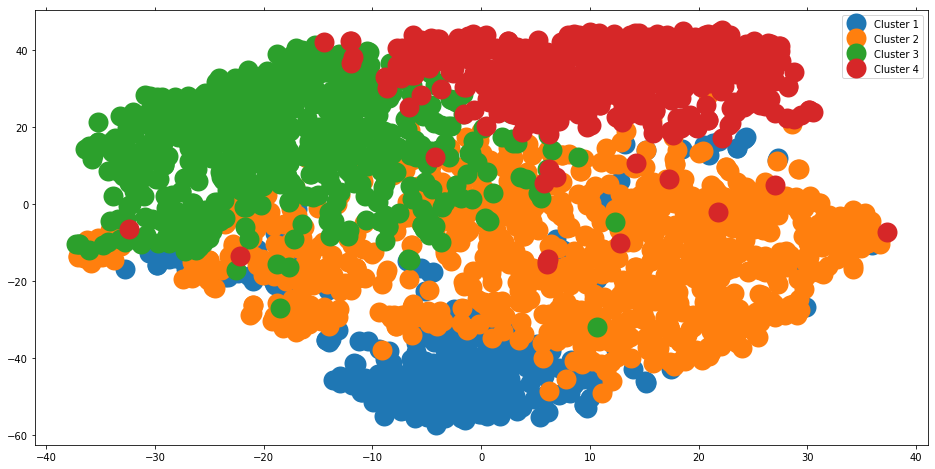

In [113]:
plotClusters(tfidf, 4, True)

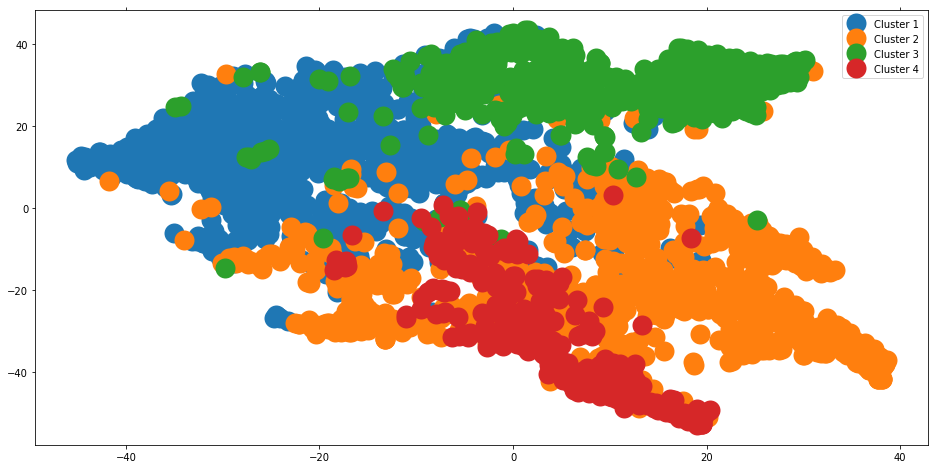

In [119]:
plotClusters(similarity_matrix, 4, False)

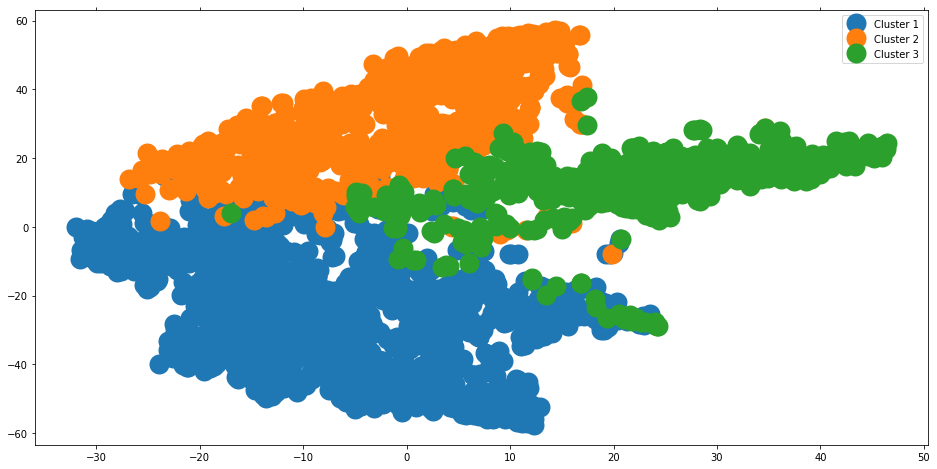

In [125]:
plotClusters(avg_features, 3, True)

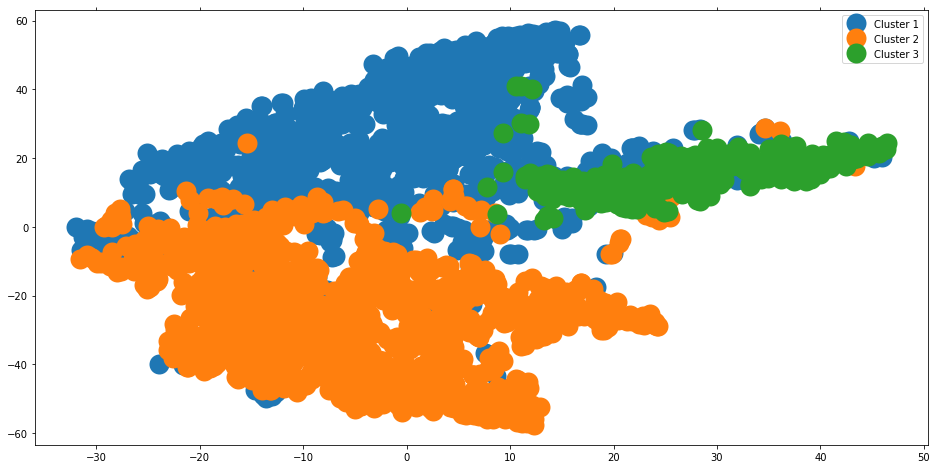

In [124]:
plotClusters(avg_features, 3, False)

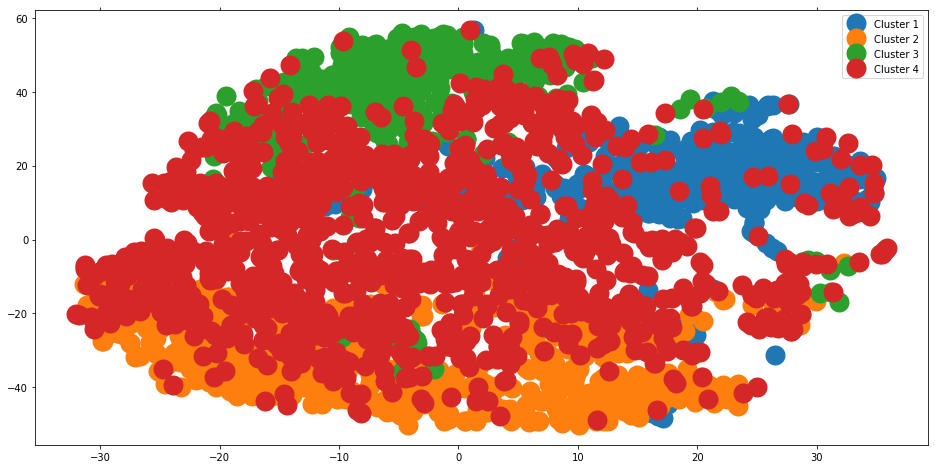

In [122]:
plotClusters(document_vector, 4, True)

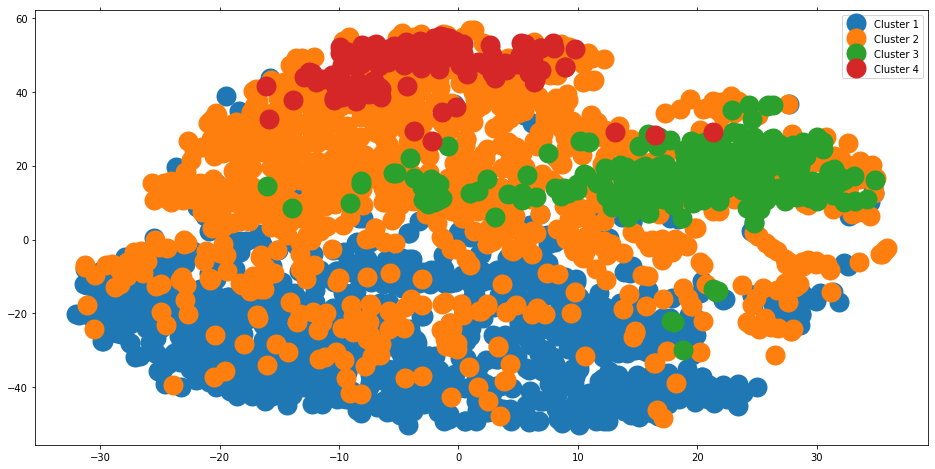

In [123]:
plotClusters(document_vector, 4, False)